In [45]:
from pathlib import Path

import awkward as ak
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, skew
from gsfanalysis.tracksummary_plots import *
from gsfanalysis.pandas_import import *
from gsfanalysis.core_tail_utils import *

In [46]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Import

In [47]:
inputDir = Path("../output/odd_g4_n20_4GeV")

summary_gsf_root = uproot.open(str(inputDir / "root/tracksummary_gsf.root:tracksummary"))
states_gsf_root = uproot.open(str(inputDir / "root/trackstates_gsf.root:trackstates"))

summary_kf_root = uproot.open(str(inputDir / "root/tracksummary_kf.root:tracksummary"))
states_kf_root = uproot.open(str(inputDir / "root/trackstates_kf.root:trackstates"))

In [48]:
summary_gsf, states_gsf = uproot_to_pandas(summary_gsf_root, states_gsf_root)
summary_kf, states_kf = uproot_to_pandas(summary_kf_root, states_kf_root)

In [49]:
summary_gsf.head(3)

,event_nr,multiTraj_nr,nStates,nMeasurements,nOutliers,nHoles,nSharedHits,chi2Sum,NDF,nMajorityHits,...,res_eT_fit,pull_eLOC0_fit,pull_eLOC1_fit,pull_ePHI_fit,pull_eTHETA_fit,pull_eQOP_fit,pull_eT_fit,p_fit,res_p_fit,t_delta_p
0,0,0,28,15,0,0,0,175.065445,26,15,...,142.000443,-0.847115,-2.244259,1.173481,-2.410385,0.835114,0.047366,4.042051,0.042562,-0.030813
1,0,1,28,15,0,0,0,273.008057,26,15,...,117.682442,2.596446,1.258761,-1.802015,-0.027044,0.648392,0.039255,4.016548,0.017059,-0.028131
2,0,2,27,5,5,2,0,831.616516,17,5,...,-144.733704,-4.054999,1.284886,3.975626,-1.376495,3.679446,-0.048278,86.514519,82.515030,-0.320399


In [50]:
summary_kf.head(3)

,event_nr,multiTraj_nr,nStates,nMeasurements,nOutliers,nHoles,nSharedHits,chi2Sum,NDF,nMajorityHits,...,res_eT_fit,pull_eLOC0_fit,pull_eLOC1_fit,pull_ePHI_fit,pull_eTHETA_fit,pull_eQOP_fit,pull_eT_fit,p_fit,res_p_fit,t_delta_p
0,0,0,28,15,0,0,0,17.678459,26,15,...,142.026474,-0.663642,-1.834799,0.938987,-2.545485,-0.313325,0.047375,3.986071,-0.013418,-0.030813
1,0,1,28,15,0,0,0,34.860538,26,15,...,117.689255,2.540377,1.257176,-1.781578,-0.031880,0.098892,0.039257,4.002743,0.003254,-0.028131
2,0,2,27,10,0,2,0,124.749222,17,10,...,-159.439331,1.183495,-1.082811,-3.645324,-0.826318,-30.493053,-0.053183,2.930712,-1.068777,-1.468329


## Overview plots

In [51]:
def delta_p_vs_res_qop(df_gsf, df_kf):
    fig, axes = plt.subplots(1,2,figsize=(16,5))
    
    for ax, df, fitter in zip(axes, [df_gsf, df_kf], ["GSF", "KF"]):
        ax.scatter(np.clip(df.res_eQOP_fit, -5,.5), df.t_delta_p, alpha=0.1)
        ax.set_ylabel("$\Delta p$ [GeV]")
        ax.set_xlabel("${q/p}_{{fit}} - {q/p}_{{true}} \quad [1/GeV]$")
        ax.set_title(fitter)
        ax.set_xlim(-5,.5)
        
    return fig, ax

In [52]:
"tracks with outliers : {:.2%}".format(sum(np.unique(summary_gsf["nOutliers"], return_counts=True)[1][1:]) / len(summary_gsf))

'tracks with outliers : 16.79%'

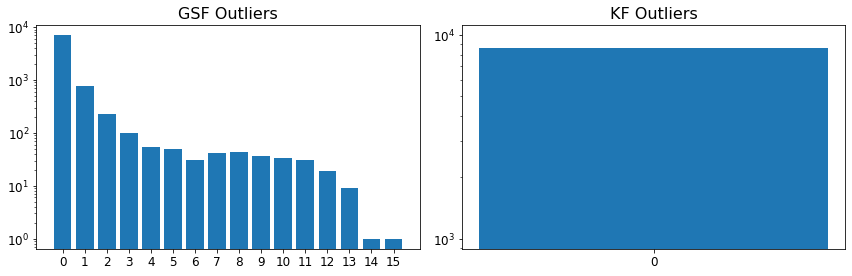

In [53]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

for ax, df, fitter in zip(axes, [summary_gsf, summary_kf], ["GSF", "KF"]):
    ax.bar(*np.unique(df["nOutliers"], return_counts=True))
    ax.set_title(f"{fitter} Outliers")
    ax.set_yscale('log')
    _ = ax.set_xticks(np.unique(df["nOutliers"]))
    
fig.tight_layout()

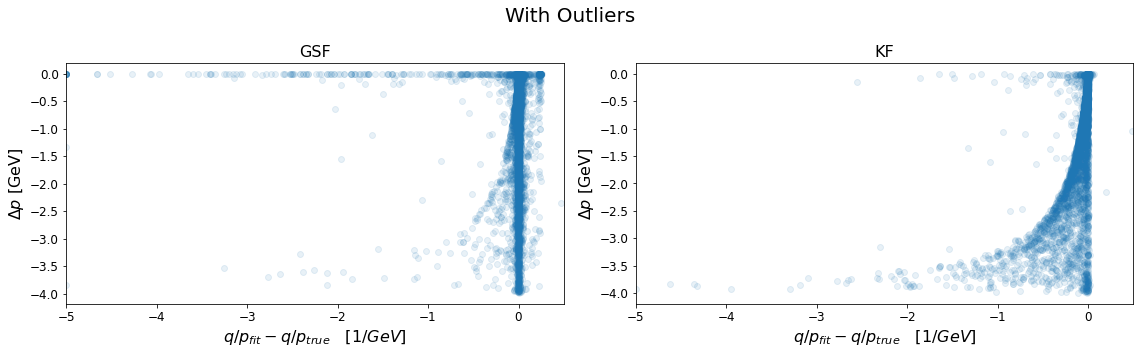

In [54]:
fig, _ = delta_p_vs_res_qop(summary_gsf, summary_kf)
fig.suptitle("With Outliers")
fig.tight_layout()

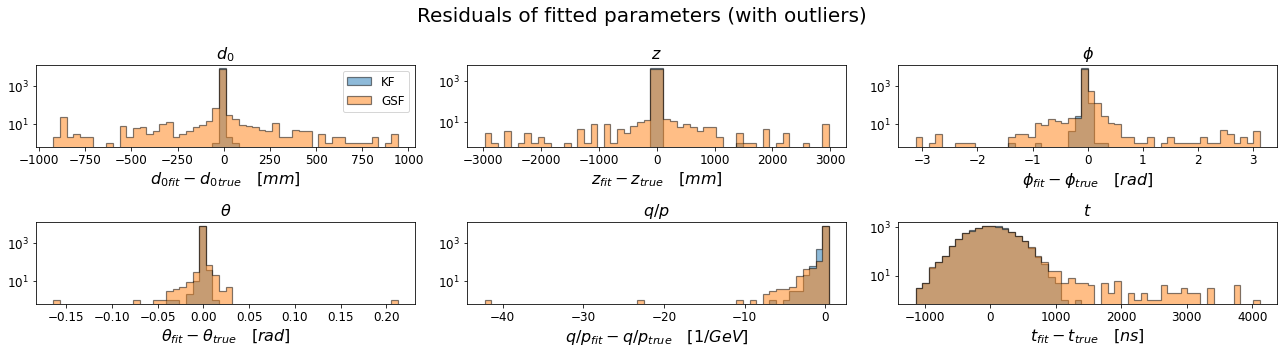

In [55]:
fig, _ = make_full_residual_plot([summary_kf, summary_gsf], ["KF", "GSF"])
fig.suptitle("Residuals of fitted parameters (with outliers)")
fig.tight_layout()

## Remove outliers

In [56]:
summary_gsf_no_outliers = summary_gsf[ summary_gsf["nOutliers"] == 0 ]
common_idx = summary_gsf_no_outliers.index.intersection(summary_kf.index)

summary_kf_no_outliers = summary_kf.loc[common_idx, :]
summary_gsf_no_outliers = summary_gsf_no_outliers.loc[common_idx, :]

In [57]:
len(summary_gsf), len(summary_kf)

(8580, 8662)

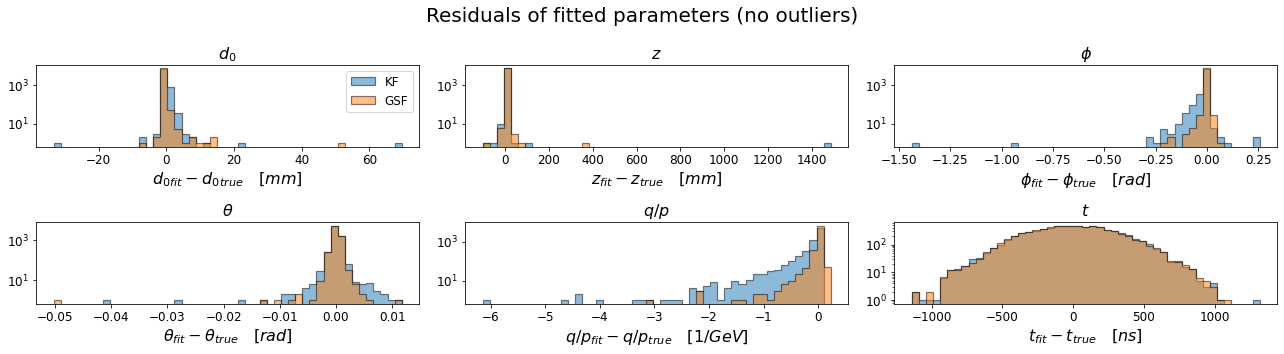

In [58]:
fig, _ = make_full_residual_plot([summary_kf_no_outliers, summary_gsf_no_outliers], ["KF", "GSF"])
fig.suptitle("Residuals of fitted parameters (no outliers)")
fig.tight_layout()

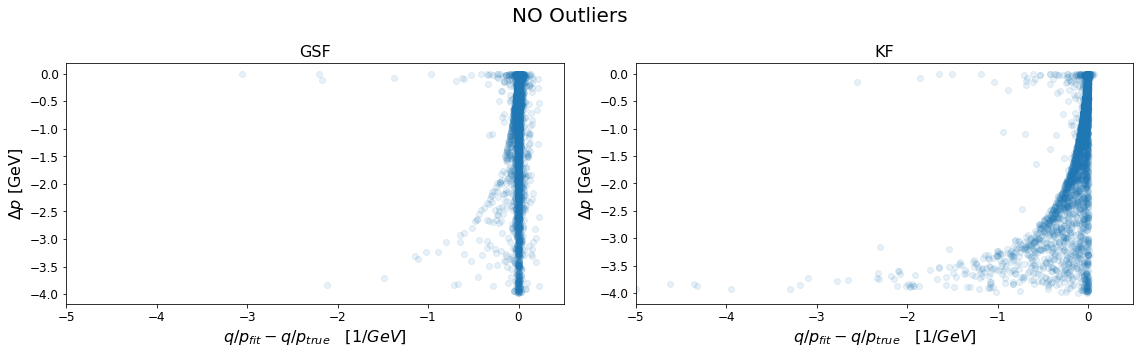

In [59]:
fig, _ = delta_p_vs_res_qop(summary_gsf_no_outliers, summary_kf_no_outliers)
fig.suptitle("NO Outliers")
fig.tight_layout()

## Core-Tail resolution

In [60]:
def rms(x):
    return np.sqrt(np.mean(np.square(x)))

In [61]:
def add_core_tail_to_df_rms(df, key, target_rms, target_tol = 1e-3):
    def eval_core(share):
        d = np.quantile(np.sort(abs(df[key])), share)     
        core_range = (-d, d)
        df["is_core"] = df[key].between(*core_range)
        return rms(df[ df["is_core"] ][key])
        
    # Compute core range
    a = 0.0
    b = 1.0
    current_rms = rms(df[key])
    
    for n in range(100):
        c = 0.5 * (a + b)
        
        current_rms = eval_core(c)
        print(c, current_rms)
        if abs(current_rms - target_rms) < target_tol:
            print("final rms",current_rms)
            return df
        
        if current_rms > target_rms:
            b = c
        else:
            a = c   
    
    return None

In [62]:
def sweep_core_share(df, key, mean_ylim):
    fig, ax = plt.subplots(1,2, figsize=(16,5))
    core_mean = []
    core_rms = []
    tail_mean = []
    tail_rms = []
    #core_share = [0.0, 0.01, 0.1, 0.2, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999, 1.0]
    #core_share = [0.0, 0.5, 0.8, 0.9, 0.95, 0.975, 0.99, 0.999, 0.9999, 1.0]
    core_share = np.linspace(0,0.9,20).tolist() + np.linspace(0.9,1,20).tolist()
    #print(core_share)
    #core_share = [0.9, 0.925, 0.95, 0.96, 0.975, 0.98, 0.985, 0.99, 0.999, 0.9999, 1.0 ]
    
    ax[0].hlines(np.mean(df[key]), min(core_share), max(core_share), color="grey", label="sample mean")
    ax[1].hlines(rms(df[key]), min(core_share), max(core_share), color="grey", label="sample rms")

    for share in core_share:
        df = add_core_to_df_quantile(df, "res_eQOP_fit", share)

        core_part = df[df["is_core"]]
        tail_part = df[np.logical_not(df["is_core"])]
        
        #print("share:",len(core_part)/len(df), share,len(core_part),len(tail_part))

        core_mean.append(np.mean(core_part[key]))
        core_rms.append(rms(core_part[key]))
        tail_mean.append(np.mean(tail_part[key]))
        tail_rms.append(rms(tail_part[key]))
        
    #print(core_mean)
    #print(tail_mean)
    
    ax[0].plot(core_share, core_mean, label="core_mean")
    ax[0].plot(core_share, tail_mean, label="tail_mean")
    ax[0].set_xlabel("core share [%]")
    ax[0].set_ylabel("mean")
    ax[0].set_title("mean")
    #ax[0].set_xscale('log')
    #ax[0].set_yscale('symlog')
    ax[0].legend()
    ax[0].set_ylim(*mean_ylim)
    
    ax[1].plot(core_share, core_rms, label="core_rms")
    ax[1].plot(core_share, tail_rms, label="tail_rms")
    ax[1].set_xlabel("core share [%]")
    ax[1].set_ylabel("RMS")
    ax[1].set_title("RMS")
    #ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].legend()
    
    return fig, ax

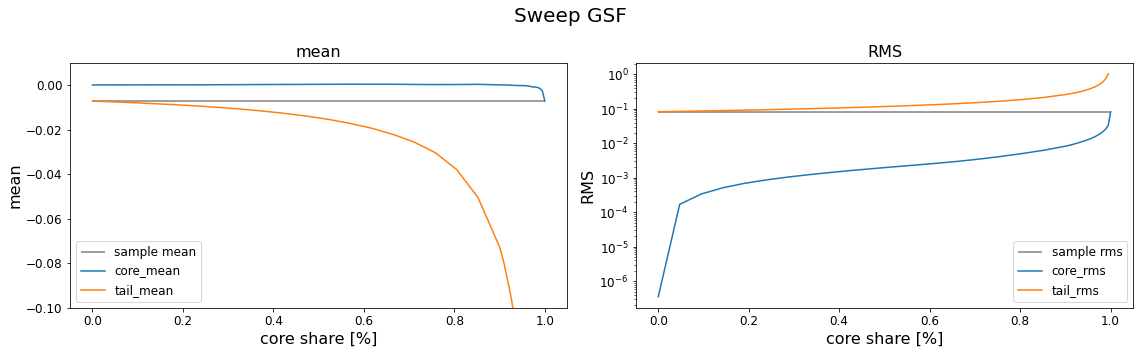

In [63]:
fig, ax = sweep_core_share(summary_gsf_no_outliers.copy(), "res_eQOP_fit", mean_ylim=(-0.1,0.01))
fig.suptitle("Sweep GSF")
fig.tight_layout()

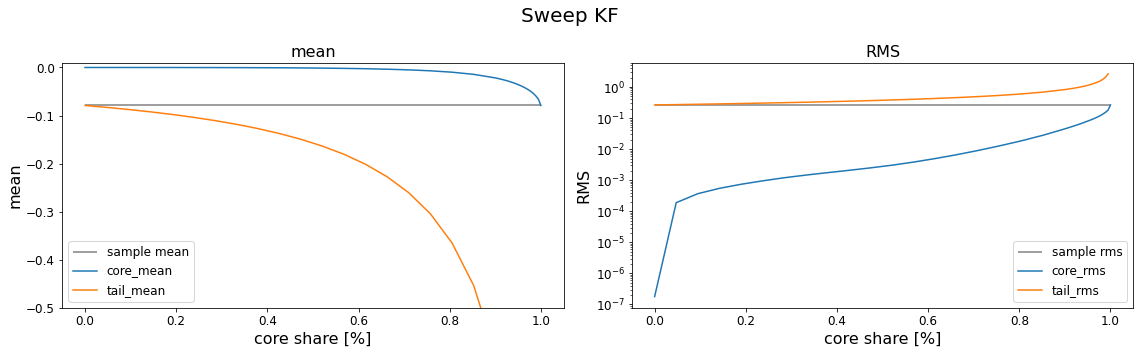

In [64]:
fig, ax = sweep_core_share(summary_kf_no_outliers.copy(), "res_eQOP_fit", mean_ylim=(-0.5,0.01))
fig.suptitle("Sweep KF")
fig.tight_layout()

In [65]:
summary_gsf_no_outliers = add_core_to_df_quantile(summary_gsf_no_outliers, "res_eQOP_fit", 0.95)
summary_kf_no_outliers = add_core_to_df_quantile(summary_kf_no_outliers, "res_eQOP_fit", 0.95)
#summary_gsf_no_outliers = add_core_tail_to_df(summary_gsf_no_outliers, "res_eLOC0_fit", 0.95)
#summary_kf_no_outliers = add_core_tail_to_df(summary_kf_no_outliers, "res_eLOC0_fit", 0.95)

In [66]:
#summary_gsf_no_outliers = add_core_tail_to_df_rms(summary_gsf_no_outliers, "res_eQOP_fit", 0.015)
#summary_kf_no_outliers = add_core_tail_to_df_rms(summary_kf_no_outliers, "res_eQOP_fit", 0.015)

In [67]:
def analyse_core_tail(df, key, clip_range=None):
    if clip_range is None:
        clip_range = ( min(df[key]), max(df[key]) )
        
    assert clip_range[0] < 0.0
    assert clip_range[1] > 0.0
    
    core_percent = 100. * sum(df["is_core"]) / len(df)
    tail_percent = 100. - core_percent
    
    core_part = df[df["is_core"]]
    tail_part = df[np.logical_not(df["is_core"])]
        
    fig, axes = plt.subplots(2,2,figsize=(20,10))
    axes = axes.flatten()
     
    all_label  = "all (100.0%)    |    E(X)={:.3f}, RMS(X)={:.3f}".format(np.mean(df[key]), rms(df[key]))
    tail_label = "tail ({:.1f}%)    |    E(X)={:.3f}, RMS(X)={:.3f}".format(tail_percent, np.mean(tail_part[key]), rms(tail_part[key]))
    core_label = "core ({:.1f}%)    |    E(X)={:.3f}, RMS(X)={:.3f}".format(core_percent, np.mean(core_part[key]), rms(core_part[key]))
    hist_options = dict(edgecolor='black', linewidth=1.2, stacked=True, label=[core_label, tail_label], color=["tab:orange", "tab:blue"])
        
    # Whole plot
    _, bins = np.histogram(np.clip(df[key], *clip_range), bins=50)
    _, bins, _ = axes[0].hist([np.clip(core_part[key], *clip_range), np.clip(tail_part[key], *clip_range)], bins=bins, **hist_options)
    axes[0].hist(np.clip(df[key], *clip_range), bins=bins, histtype='step', color='grey', label=all_label)
    axes[0].set_yscale('log')
    axes[0].legend()
    axes[0].set_title("Whole range")
    
    # Zoom plot
    zoom = lambda x: x[ np.logical_and(x > 3*min(core_part[key]), x < 3*max(core_part[key])) ]
    
    _, bins = np.histogram(zoom(df[key]), bins=50)
    axes[1].hist([core_part[key], zoom(tail_part[key])], bins=bins, **hist_options)
    axes[1].set_yscale('log')
    #axes[1].legend()
    axes[1].set_title("Zoom range")
    
    # Pull distribution core
    for ax, pull_df, title, color in zip(axes[2:], [df, core_part], ["Pull Core+Tail", "Pull Core"], ["grey", "tab:orange"]):
        pull = pull_df["pull_" + key[4:]]
        pull = pull[ np.isfinite(pull) ]
        fit_pull = norm.fit(pull)
        ax.hist(pull, bins="rice", density=True, color=color)
        x = np.linspace(*ax.get_xlim(), 200)
        ax.plot(x, norm.pdf(x, *fit_pull), label="$\mu$={:.3f}, $\sigma$={:.3f}".format(*fit_pull), color='red', lw=2.0)
        ax.legend()
        ax.set_title(title)
        
    return fig, axes

### QOP

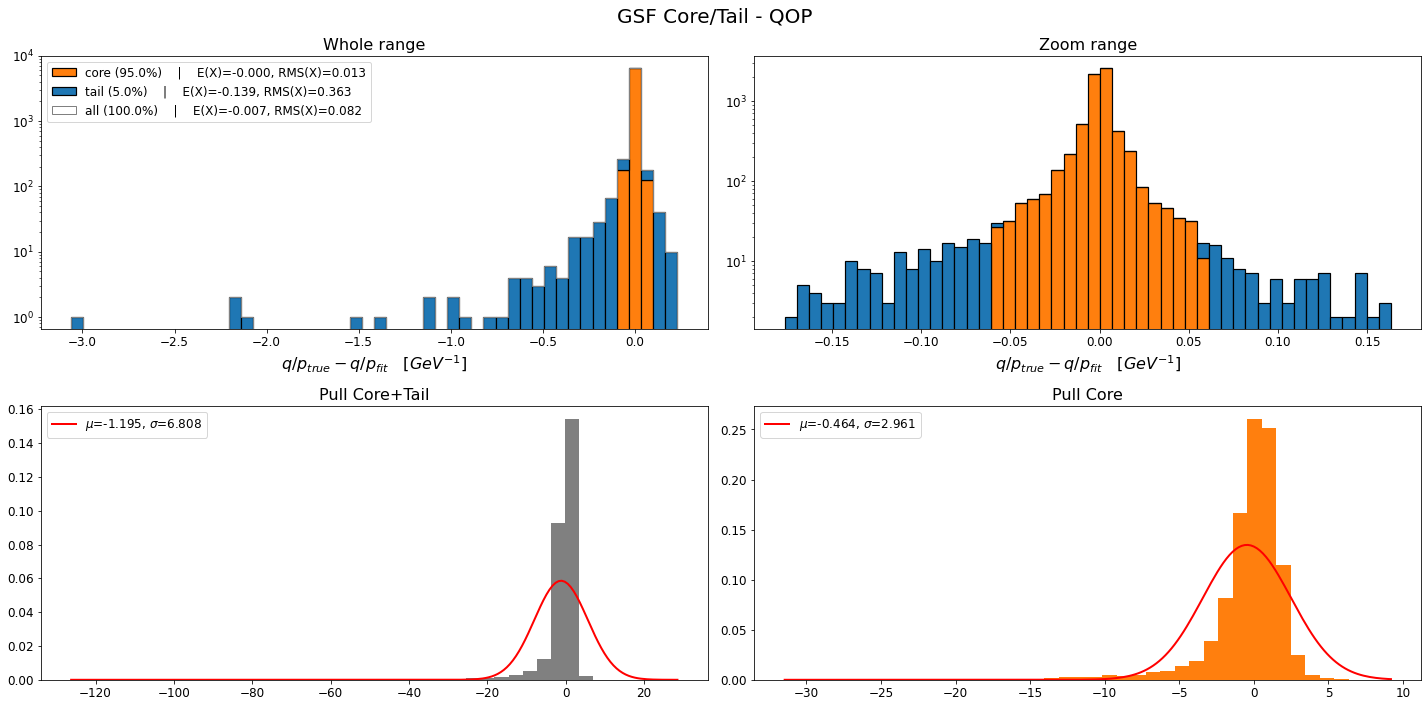

In [68]:
fig, axes = analyse_core_tail(summary_gsf_no_outliers, "res_eQOP_fit")
for ax in axes[:2]:
    ax.set_xlabel("$q/p_{true} - q/p_{fit} \quad [GeV^{-1}]$")
fig.suptitle("GSF Core/Tail - QOP")
fig.tight_layout()

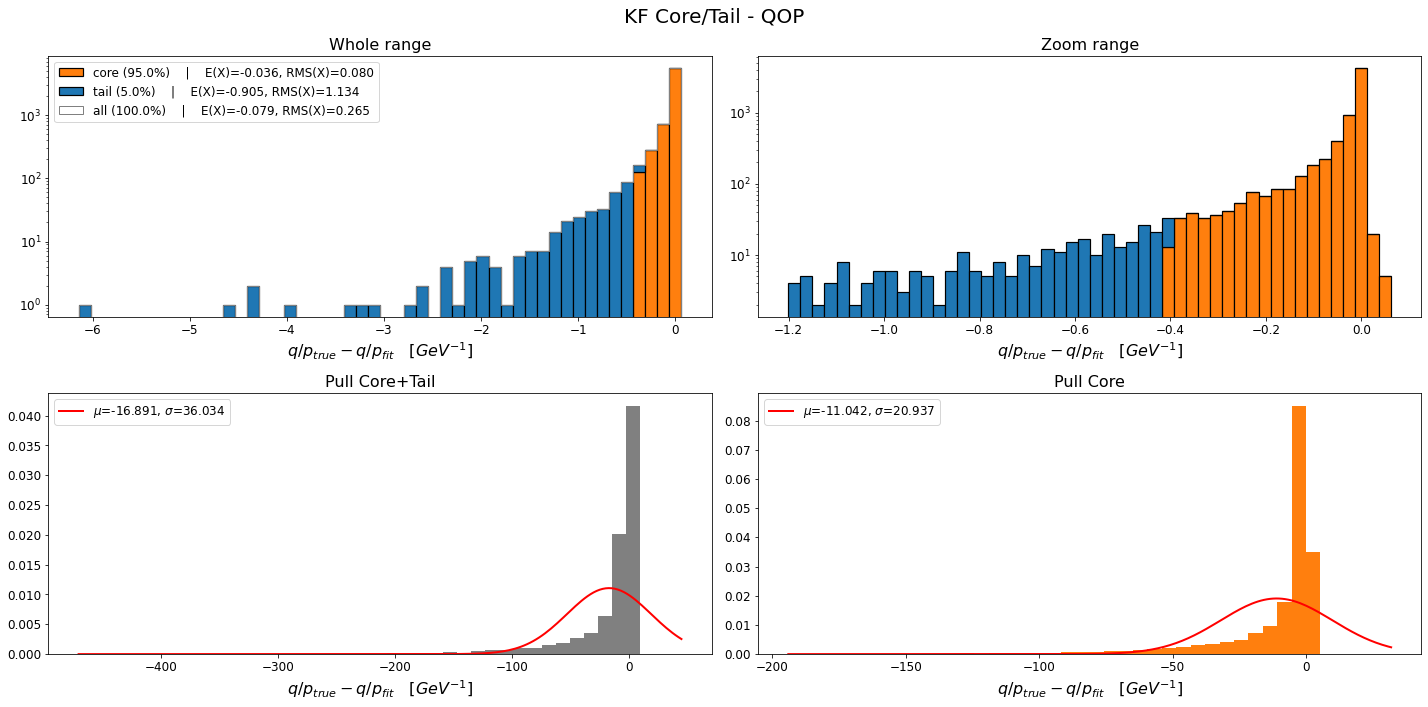

In [69]:
fig, axes = analyse_core_tail(summary_kf_no_outliers, "res_eQOP_fit")
for ax in axes:
    ax.set_xlabel("$q/p_{true} - q/p_{fit} \quad [GeV^{-1}]$")
fig.suptitle("KF Core/Tail - QOP")
fig.tight_layout()

### LOC0

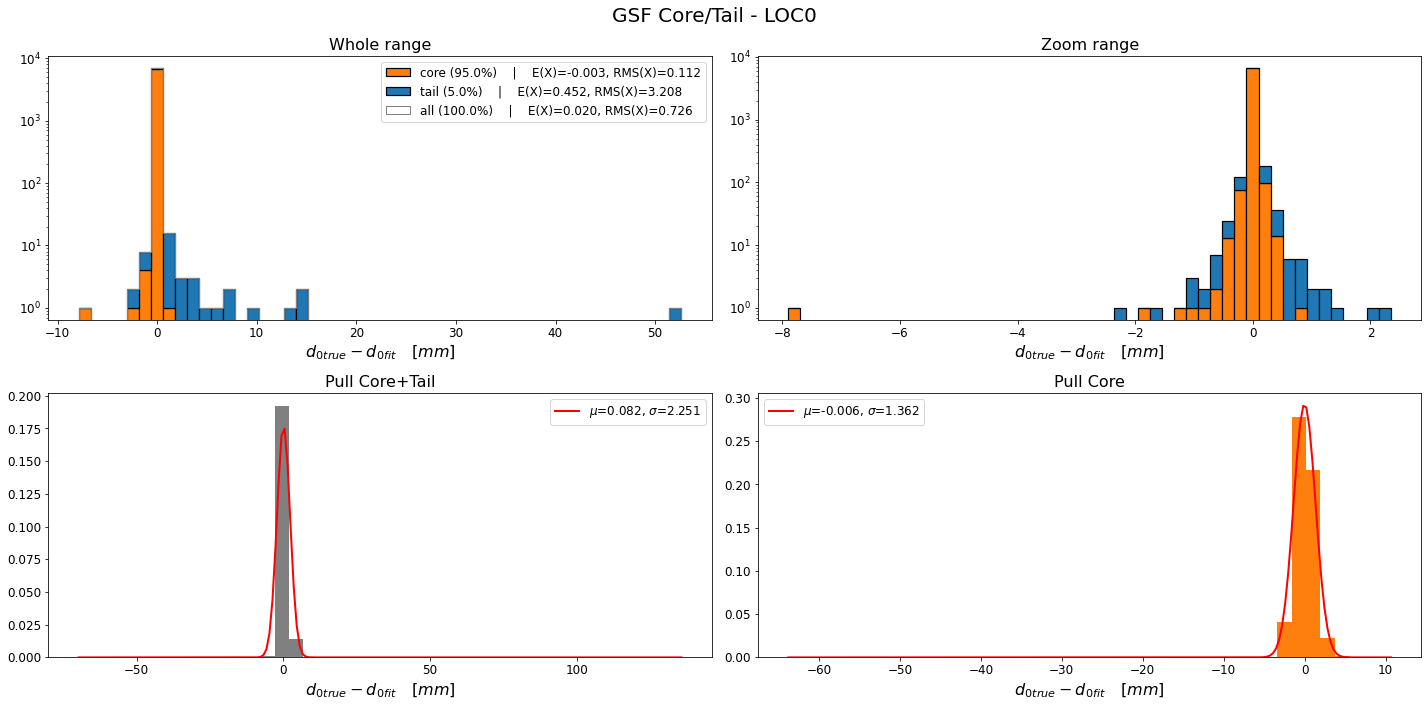

In [70]:
fig, axes = analyse_core_tail(summary_gsf_no_outliers, "res_eLOC0_fit")
for ax in axes:
    ax.set_xlabel("${d_0}_{true} - {d_0}_{fit} \quad [mm]$")
fig.suptitle("GSF Core/Tail - LOC0")
fig.tight_layout()

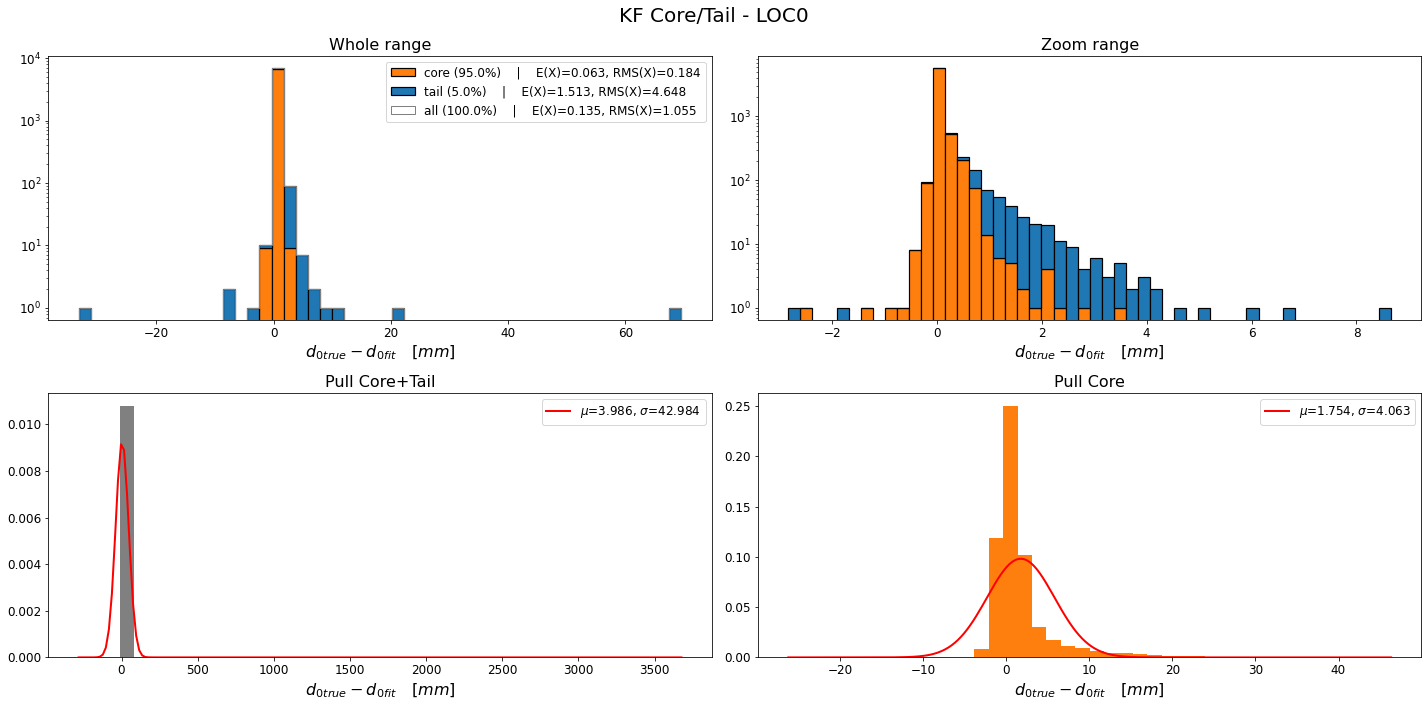

In [71]:
fig, axes = analyse_core_tail(summary_kf_no_outliers, "res_eLOC0_fit", (-100,100))
for ax in axes:
    ax.set_xlabel("${d_0}_{true} - {d_0}_{fit} \quad [mm]$")
fig.suptitle("KF Core/Tail - LOC0")
fig.tight_layout()

In [72]:
import os
if not 'LD_LIBRARY_PATH' in os.environ:
    os.environ['LD_LIBRARY_PATH'] = ""
os.environ['LD_LIBRARY_PATH'] = "/home/benjamin/.opt/cuda-12.0.1/lib64:" + os.environ['LD_LIBRARY_PATH']
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

ImportError: cannot import name 'formatargspec' from 'inspect' (/usr/lib64/python3.11/inspect.py)

In [ ]:
summary_gsf_no_outliers.columns

In [ ]:
summary_gsf_no_outliers["chi2SumByNDF"] = summary_gsf_no_outliers["chi2Sum"] / summary_gsf_no_outliers["NDF"]

In [ ]:
fit_keys = ['eLOC0_fit', 'eLOC1_fit', 'ePHI_fit','eTHETA_fit', 'eQOP_fit', 'eT_fit']
err_keys = ['err_eLOC0_fit', 'err_eLOC1_fit', 'err_ePHI_fit', 'err_eTHETA_fit', 'err_eQOP_fit', 'err_eT_fit']
stat_keys = ['nStates', 'nMeasurements', 'nOutliers', 'nHoles', 'nSharedHits', 'chi2SumByNDF' ]

train_keys = sum([
    fit_keys,
    err_keys,
    stat_keys,
], [])

x_data = summary_gsf_no_outliers[train_keys].to_numpy().astype(np.float32)
y_data = summary_gsf_no_outliers["is_core"].to_numpy().astype(np.float32)

x_data.shape

In [ ]:
mask = np.all(np.isfinite(x_data), axis=1)
x_data = x_data[mask]
y_data = y_data[mask]

In [ ]:
plt.bar(*np.unique(y_data, return_counts=True))

In [ ]:
weights = np.ones(len(x_data), dtype=np.float32)
weights[ y_data == 0.0 ] = 10.0

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(50, activation="relu", use_bias=True, input_shape=(len(train_keys),)),
        tf.keras.layers.Dense(50, activation="relu", use_bias=True),
        tf.keras.layers.Dense(1, activation="sigmoid", use_bias=True),
    ]
)
        
model.compile(optimizer=tf.optimizers.Adam(0.1), loss="bce", weighted_metrics=[tf.keras.metrics.BinaryAccuracy()])

history = model.fit(
    x_train,
    y_train,
    epochs=20,
    verbose=1,
    validation_split=0.3,
    sample_weight=weights,
)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
for key, vals in history.history.items():
    axx = ax[0] if "loss" in key else ax[1]
    axx.plot(vals, label=key)
for axx in ax:
    axx.set_xlabel("epochs")
#ax[0].set_yscale('log')
ax[0].set_title("loss")
ax[1].set_title("accuracy")
ax[0].legend()
ax[1].legend()

In [ ]:
y_pred = model(x_test).numpy()

In [ ]:
np.unique(y_pred > 0, return_counts=True)

In [ ]:
plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC: {:.2f}".format(roc_auc_score(y_test, y_pred)))